In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

**Start at:** Friday 17 November 2023, 18:06:55  
**Hostname:** zarko (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>


# TCCM Homework:<br>**Quality rating of red wines by logistic regression**

<div class="intro">
    
<p style="text-align: center"><img width="650px" src="./config/svg/vinho-verde-header.jpg" style="margin-left:auto; margin-right:auto" id="img_vinho_verde"></p>
<br>

1. The purpose of this project is to **predict the quality** of Portuguese Vinho Verde wines based on their **physicochemical components**. The intent is to **replace a panel of wine tasters with an artificial neural network**.

2. Two **datasets** (one for white wines and the other for red wines) are downloadable on the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality). The input variables (descriptors) are
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Whereas the output variable, ***i.e.* the target**, is a 0 to 10 quality score, based on sensory data

3. **Bibliography**. There are two main references:
- An [original paper](https://doi.org/10.1016/j.dss.2009.05.016): Modeling wine preferences by data mining from physicochemical properties (**2009**), by Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos, José Reis, *Decision Support Systems* **47**: 547-553
- A [Wine Project github repository](https://github.com/kmspitzer/final-wineproject), at the core of the [Wine Quality website](https://ucsd-winequality.herokuapp.com/). Authors explored several classifiers: K Nearest Neighbors, Decision Tree, Random Forest, Random Forest Regressor, Stochastic Gradient Descent, Support Vector Classification, Linear Support Vector Classification, AdaBoost Classifier, Gradient Boost Classifier, XGB Classifier, and obtained 69% to 95% performance, the highest being from the Random Forest Regression, Random Forest, and XGBoost models.

Some useful pieces of codes will be found on the previous website as well as on the present PytChem repository. If you analyze the ML notebooks carefully, you will see that some pieces of code such as automatic one-hot encoding etc... are available, although they might have not been used during the talktorials (see the [DS4B-Appendix.ipynb notebook](./DS4B-Appendix.ipynb) and the [tools4PytChem.py scripts](./config/tools4PytChem.py))

4. **Mandatory implementation**.
- The code will be developed in Python, in **this Jupyter notebook**, using mainly the Keras and Tensorflow ML libraries, although some ML SciKit Learn tools can also be used, if necessary.
- It will be commented both using **Markdown cells** and **Python block comments or inline comments**.
- No separate report is required, the **final present notebook** will be used both to evaluate the code and to explain the purpose of each section and how the results should be analyzed.
- Particular attention will be paid to the **organization of the notebook**: use headers, ordered or unordered list of items, tables, mathematical formulas, hyperlinks, images, ....
- As done in the [Wine Project](https://github.com/kmspitzer/final-wineproject), **data will be cleaned and prepared**. A correlation matrix will plotted. You will do that separately for white and red wines. It could be interesting - or not -  to build a database mixing red and white wines, with a 12th descriptor for the wine color.
- You will try either a **simple ANN** and a **deep learning approach**. In addition to the accuracy of each tested ANN architecture, a **confusion matrix** would be helpful to better assess their performance.
- The numerical stability of the best model will be assessed using a **5-fold cross validation**.
</div>


### Preliminary comments

<div class="intro" title="Preliminary Considerations">
I strongly advise not to re-run this notebook. Some cells are very expensive to run and it can take a lot of time. If you decide to run it anyways, the cell below will install all packages needed to run this notebook. Some of them are quite heavy and downloading them takes some time. For data preprocessing I used scikit-learn. Two linear models were built (using scikit-learn) to serve as the baseline for comparison with the neural network models. I decided to build neural networks in PyTorch and use skorch wrapper. Hyperparameters optimization was done using scikit-optimize for two linear models, and raytune for neural networks. SMOTE method of unbalanced sampling comes from imblearn library.
</div>

In [ ]:
# Run this cell to check if you have all the packages installed!
%pip install "numpy<1.24.0" pandas seaborn matplotlib skorch imblearn torch scikit-learn scikit-optimize "ray[tune]"

In [2]:
# Importing all packages that will be used in the notebook
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
#import warnings
#warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from ray.tune.sklearn import TuneGridSearchCV
from ray.tune.sklearn import TuneSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from torch import nn, manual_seed, set_default_dtype, float64, device, cuda
torch.manual_seed(7)
from skorch import NeuralNetClassifier, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
pd.set_option("display.width", 180)
pd.set_option('max_colwidth', 10)

In [3]:
# Reading datasets
white_wine = pd.read_csv("datasets/winequality-white.csv",delimiter=';')
red_wine = pd.read_csv("datasets/winequality-red.csv",delimiter=';')

In [ ]:
white_wine.isnull().any()

In [ ]:
red_wine.isnull().any()

## Dataset Exploration and Visualization
<div class="intro">
First we need to visualize features in the dataset, their types, distribution of their values, and fix potential issues, such as missing values or errors. Fortunately, this dataset is already preprocessed, so we don't have any missing values or errors. Then the features are separated from targets. Then we need to split our dataset into training and test set. Validation will be done using 5-fold stratified cross-validatio, so there is no need for validation set. This way we can train our models on more data. First we will inspect features, their distribution and correlation. The target we want to predict is score of wine quality. Discussion of the dataset and conclusions are <a href='#dataset_analysis'>here</a>
</div>

#### Feature types

In [ ]:
white_wine.dtypes

In [ ]:
red_wine.dtypes

All features have numerical values and our target is integer. Therefore we don't need to perform any type of encoding. For performance, we will cast features to float32.

#### Dataset splitting

In [4]:
X_white = white_wine.drop("quality",axis=1).astype(np.float32)
X_red = red_wine.drop("quality",axis=1).astype(np.float32)
Y_white = white_wine[["quality"]]
Y_red = red_wine[["quality"]]

test_ratio = 0.20
x_white_train, x_white_test, y_white_train, y_white_test = train_test_split(X_white, Y_white, test_size=test_ratio,random_state=7)
x_red_train, x_red_test, y_red_train, y_red_test = train_test_split(X_red, Y_red, test_size=test_ratio,random_state=7)

features = list(x_white_train.columns)

### Summary of the training set

#### Basic statistical analysis

In [ ]:
print(x_white_train.join(y_white_train).describe())

In [ ]:
print(x_red_train.join(y_red_train).describe())

#### Random sample from each dataset

In [ ]:
print(x_white_train.join(y_white_train).sample(10))

In [ ]:
print(x_red_train.join(y_white_train).sample(10))

#### Pairplot of features

In [ ]:
sns.pairplot(data=x_white_train.join(y_white_train), hue="quality");

In [ ]:
sns.pairplot(data=x_red_train.join(y_white_train), hue="quality");

#### Features and target distributions

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_white_train.join(y_white_train).items():
    sns.histplot(value, ax=ax[index], kde=True)
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_red_train.join(y_red_train).items():
    sns.histplot(value, ax=ax[index], kde=True)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_white_train.join(y_white_train).items():
    sns.pointplot(x=y_white_train.squeeze(), y=value.squeeze(), ax=ax[index],hue=y_white_train.squeeze() ,legend=False)
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in x_red_train.join(y_red_train).items():
    sns.pointplot(x=y_red_train.squeeze(), y=value.squeeze(), ax=ax[index],hue=y_red_train.squeeze() ,legend=False)
    ax[index].xaxis.set_tick_params(labelsize=8)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

#### Correlation Matrix

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(x_white_train.corr(numeric_only=True), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(x_red_train.corr(numeric_only=True), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');

## Dataset Analysis <a id='dataset_analysis'></a>

<div class="rqT" title="Observations">

1. The range of values features take is different for different features. Therefore, standardization of feature values must be performed. However, distributions of features are scewed due to presence of outliers.

2. We can spot certain outlayers in pairplot graph. However, those can't be just discarder, as the analysis showed that most of them are from the underrepresnted quality scores.

3. Wines of very good or very bad quality are not sufficiently represented in the dataset. There are very little wines with quality smaller than 4 or greater than 7. There are no red wines with quality higher than 8! Moreover, we can see that extremes in termes of quality have very widespread distribution of features (see pointplots).

4. Features are generally not correlated, with one important exception for white wines: density is highly correlated with residual sugar and alcohol features.

</div>

### Conclusions and decisions about models
<div class="rqT">
    
1. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html"> RobustScaler </a> from scikit-learn library will be used to scale the features, as it's more robust for cases where we have a lot of outliers in the distribution.
2. Outliers will not be removed, as many of them belond to the underrepresented class.
3. Dataset will be augmented using  <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html"> SMOTE </a> technique for imbalanced datasets.
4. As we have only 11 features, and almost all of them show little correlation, there is no need for feature selection. We will keep all features.
</div>

<div class="intro" >
Our target is the quality score, an integer from 0-10. This is a problem of ordinal classification. The simplest approach would be to use any multi-label classification algorithm, such as multinomial logistic regression (also known as softmax regression) with negative log likelihood loss. However, this doesn't take into account order of labels. For instance, missclassifying wine of quality 8 as 1 is penalized the same was as missclassifiying it as 6. However, we would like to punish more the mistakes that are further away from the true value. Therefore, the imporeved model would use regression with mean square error as the loss function. The prediction would then be computed in a separate step, rounding output of the model to the nearest integer. I will test two linear models and two neural networks.
</div>

<div class="rqT" title="Models">

1. Two linear models, implemented in sckit-learn:
* Linear Logistic Regressor
* Linear Ridge Regressor
2. Two ANN models implemented in PyTorch:
* Neural Net Classifier
* Neural Net Regeressor

The first two models will be used as a baseline to compare other two models. Hyperparameters for all models will be optimized using 5-fold cross validation. Finally, Each model will be evaluated on the test set. Accuracy and confusion matrices will be calculated.
</div>

## Bulding models

### Linear Ridge Regression for ordinal classification
For linear regression model, I opted for <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">Ridge model</a>. It's relatively simple model with only one regularization parameters that punishes the size of coefficient in linear regression.

In [12]:
# Modifying regression so it can compute integer wine quality score
class OrdinalRegressionClassifier(Ridge):
    def decision_function(self,X):
        return np.round(super().predict(X))

model1_red = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,)),
                 ("regressor",OrdinalRegressionClassifier(random_state=7,alpha=23)),
                 ])
model1_white = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,k_neighbors=3)),
                 ("regressor",OrdinalRegressionClassifier(random_state=7,alpha=25.36)),
                 ])
param_grid1 = [
  {
  'data_augmentation' : Categorical(['passthrough']),
  'regressor__alpha' : Real(1e-1, 1e+3, prior='log-uniform'),
  },
 ]

<div class="intro">
Because the training data is unbalanced, hyperparameter optimization will always prefer not to augment data because we are using negative MSE as the scoring function. However, if we are interested in find only excellent wines from the group of wines, this is not the metric we want to optimize. Because of that, I will test an additional model trained on augemnted dataset for each model.
</div>

<div class="rqT" title="Side note">
White dataset has
</div>

In [13]:
hiperparam_opt1_red = BayesSearchCV(
    model1_red, search_spaces=param_grid1, scoring='neg_mean_squared_error', random_state=7,
)
hiperparam_opt1_white = BayesSearchCV(
    model1_white, search_spaces=param_grid1, scoring='neg_mean_squared_error', random_state=7,
)
hiperparam_opt1_red.fit(x_red_train, y_red_train)
hiperparam_opt1_white.fit(x_white_train, y_white_train)

BayesSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                        ('data_augmentation',
                                         SMOTE(k_neighbors=3, random_state=7)),
                                        ('regressor',
                                         OrdinalRegressionClassifier(alpha=25.36,
                                                                     random_state=7))]),
              random_state=7, scoring='neg_mean_squared_error',
              search_spaces=[{'data_augmentation': Categorical(categories=('passthrough',), prior=None),
                              'regressor__alpha': Real(low=0.1, high=1000.0, prior='log-uniform', transform='normalize')}])

In [14]:
print(hiperparam_opt1_white.best_params_)
print(hiperparam_opt1_red.best_params_)

OrderedDict([('data_augmentation', 'passthrough'), ('regressor__alpha', 25.361493115218128)])
OrderedDict([('data_augmentation', 'passthrough'), ('regressor__alpha', 23.00636239962104)])


In [9]:
model1_white.fit(x_white_train,y_white_train)
model1_red.fit(x_red_train,y_red_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('data_augmentation', SMOTE(random_state=7)),
                ('regressor',
                 OrdinalRegressionClassifier(alpha=26.12, random_state=7))])

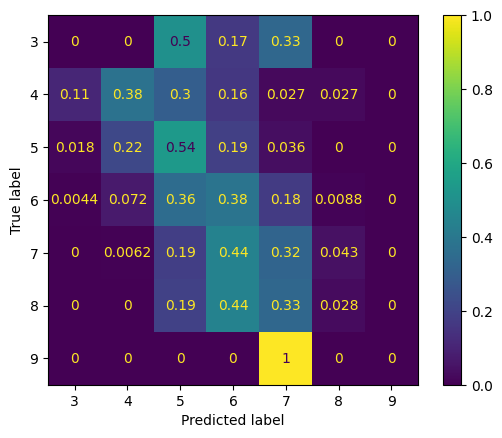

In [78]:
Y_predict1_white = model1_white.decision_function(x_white_test)
ConfusionMatrixDisplay.from_predictions(y_white_test,Y_predict1_white,labels=[3,4,5,6,7,8,9],normalize='true');

In [80]:
print(balanced_accuracy_score(y_white_test,Y_predict1_white))
print(accuracy_score(y_white_test,Y_predict1_white))

0.2329710621690571
0.4010204081632653


/home/zarko/TCCM/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### Linear logistic regression for ordinal classification

In [31]:
model2_white = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,k_neighbors=3)),
                 ("regressor",LogisticRegression(multi_class='multinomial',
                                                 class_weight='balanced',
                                                 C=1e-1,
                                                 max_iter=1000,
                                                 solver='newton-cg',
                                                 random_state=7)),
                 ])
model2_red = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7)),
                 ("regressor",LogisticRegression(multi_class='multinomial',
                                                 class_weight='balanced',
                                                 C=1e-1,
                                                 max_iter=1000,
                                                 solver='newton-cg',
                                                 random_state=7)),
                 ])
param_grid2 = [
  {
   'data_augmentation' : Categorical(['passthrough']),
   'regressor__C': Real(1e0, 1e+1, prior='log-uniform'),
   },
 ]

In [33]:
hiperparam_opt2_red = BayesSearchCV(
    model2_red, search_spaces=param_grid2, random_state=7, scoring='neg_mean_squared_error',
)
hiperparam_opt2_white = BayesSearchCV(
    model2_red, search_spaces=param_grid2, random_state=7, scoring='neg_mean_squared_error',cv=3
)
hiperparam_opt2_white.fit(x_white_train, y_white_train)
hiperparam_opt2_red.fit(x_red_train, y_red_train)

/home/zarko/TCCM/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/zarko/TCCM/lib/python3.10/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/zarko/TCCM/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/zarko/TCCM/lib/python3.10/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/zarko/TCCM/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/zarko/TCCM/lib/python3.10/site-packages/sklearn/utils/o

KeyboardInterrupt: 

In [ ]:
hiperparam_opt2_red.best_params_
print(hiperparam_opt2_red.best_estimator_.feature_names_in_)
hiperparam_opt2_red.best_estimator_.named_steps['feature_selection'].get_feature_names_out(hiperparam_opt2_red.best_estimator_.feature_names_in_)

In [ ]:

Y_predict2_red_predict = hiperparam_opt2_red.predict(x_red_test)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y_predict2_red_predict,labels=[3,4,5,6,7,8])


In [ ]:
print(balanced_accuracy_score(y_red_test,Y_predict2_red_predict))
print(accuracy_score(y_red_test,Y_predict2_red_predict))

## ANN Regressor for ordinal classification

In [ ]:
# Check for cuda 
device = device('cuda:0' if cuda.is_available() else 'cpu') 

In [ ]:
class ModuleRegressor(nn.Module):
    def __init__(self, n_layers=2,layer_width=50,n_features=11):
        super(ModuleRegressor,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width,1)
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        return x

In [ ]:
class NNRegressor(NeuralNetRegressor):
    def decision_function(self,X):
        return np.round(super().predict(X))
classifier_softmax = NeuralNetRegressor(
    ModuleRegressor,
    optimizer=Adam,
    max_epochs=150,
    lr=0.001,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=5,
    batch_size=128,
)
pipe3 = Pipeline([("scaler",RobustScaler()),
                  ("data_augmentation",SMOTE(random_state=7)),
                 ("classifier",classifier_softmax),
                 ])

### ANN Classifier for ordinal classification

In [ ]:
from torch import nn, manual_seed, set_default_dtype, float64, device, cuda
from torch.optim import Adam
set_default_dtype(float64)
manual_seed(7)
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
# Check for cuda 
device = device('cuda:0' if cuda.is_available() else 'cpu') 


In [ ]:
class ModuleClassifier(nn.Module):
    def __init__(self, n_layers=2,layer_width=50,n_class=10,n_features=11):
        super(ModuleClassifier,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width, n_class)
        self.softmax = nn.functional.softmax
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        x = self.softmax(x,-1)
        return x

In [ ]:
classifier_softmax = NeuralNetClassifier(
    ModuleClassifier,
    optimizer=Adam,
    max_epochs=150,
    criterion=nn.NLLLoss(),
    lr=0.001,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=5,
    batch_size=128,
)
pipe3 = Pipeline([("scaler",RobustScaler()),
                  ("data_augmentation",SMOTE(random_state=7)),
                 ("classifier",classifier_softmax),
                 ])

In [ ]:
param_grid = {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   'classifier__lr': Real(1e-6, 1e-1, prior='log-uniform'),
   'classifier__batch_size': Integer(16,256, prior="log-uniform",base=2),
   'classifier__module__n_layers': Integer(1,4),
   'classifier__module__layer_width': Integer(20,100),
   }

hiperparam_opt3_red = BayesSearchCV(
    pipe3,
    search_spaces=param_grid,
    random_state=7,
    
)

In [ ]:
hiperparam_opt3_red.fit(x_red_train,y_red_train)

In [ ]:
hiperparam_opt3_red.best_params_

In [ ]:
a = hiperparam_opt3_red.best_estimator_
history = a[-1].history
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation");
ax.legend();

In [ ]:
Y = hiperparam_opt3_red.predict(x_red_test.values)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y);
accuracy_score(y_red_test,Y)

In [ ]:
param_grid_softmax = [
  {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   },
 ]

In [ ]:
pipe_softmax = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,)),
                 ("regressor",classifier_softmax),
                 ])
grid_search_softmax = BayesSearchCV(
    pipe_softmax, search_spaces=param_grid_softmax
)
grid_search_softmax.fit(x_red_train, y_red_train)

In [ ]:
Y = classifier_softmax.predict(x_red_test)
conf_matrix = confusion_matrix(y_red_test, Y,labels=[3,4,5,6,7,8])
ConfusionMatrixDisplay.from_predictions(y_red_test,Y,labels=[3,4,5,6,7,8])

### ANN Classification for ordinal classification

In [ ]:
vID.end(cwd0)